# Lily's physiological data analysis

This script:

1. loads in all the participant data
2. Cleans up the data accordingly i.e. renames columns etc. 
3. Plots the raw data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
import os

In [2]:
# path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/"
path = "C:/Users/Monter/Projects/LH_Project/Data/"

### Functions

In [3]:
def HRV_Compute(data_df, plotting=False):
    
    # Example trial from an example participant for testing and understanding HRV
    # testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')

    # Get the values into a new variable for ease of use 
    vals = data_df['heart_rate'].values

    # Compute the sampling rate using time and number of samples 
    trialDuration = data_df['time'].values[-1] - data_df['time'].values[0] # in seconds 
    numbSamples = len(data_df['time'].values)
    sampleRate = np.round(numbSamples/trialDuration)

    # Find the peaks using an arbitrary height value, i.e. ignore all peaks below that value e.g. 600
    pks,_ = find_peaks(vals,height=750, prominence=150, distance=25)

    heart_rate = len(pks) # number of peaks in a minute 
    RR = np.diff(pks)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR)))) # Same formula as Lily's document 
    # standardDeviationOfRR = np.std(RR)

    if plotting:
        # Display plots of the heart rate and detected peaks 
        plt.plot(vals, color='r', linewidth=2)
        plt.plot(pks, vals[pks],'xk',markersize=8)
        plt.xlim([0,500])
        plt.xlabel('Time / s', fontsize=14)
        plt.ylabel('ECG', fontsize=14)
        plt.savefig('HeartRate_Example.png', dpi=600, bbox_inches='tight')
    
    return rmssd

## 1. Load all participant data collected so far

In [4]:
files = os.listdir(path)

tmpDF = None
df = None

for file in files:
    if 'json' in file:
        tmpDF = pd.read_json(path+file)
        
        if df is None:
            df = tmpDF
        else:
            df = pd.concat((df, tmpDF))        
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


## 2. Clean up the data 

### List phases present in the experiment

In [5]:
participants_to_update = df.loc[df['phase'] == 'calm_1o3', 'Participant_ID'].unique()

# Update "Condition" column to 0 for rows belonging to identified participants
for participant in participants_to_update:
    df.loc[df['Participant_ID'] == participant, 'Condition'] = 0
    
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


### For ease of analysis, rename the stress and calm conditions to numbers

e.g.
stress_1o1 and calm_1o1 will become p1 and 
stress_1o2 and calm_1o2 will become p2 etc. 

We can afford to do this now because we separated out the conditions to 0 for calm and 1 for stress so we do not need the phases in order to tell which condition the participant experienced in the experiment

This will make plotting the figures simpler, i.e. instead of seeing 6 phases (3 for the calm plut 3 for the stress conditions) we now only see 3 phases in total and we use the condition parameter to separate out which is stress and which is calm

In [6]:
# Rename the conditions from numbers to words i.e. condition 0 = calm and condition 1 = stress 
df['Condition'] = df['Condition'].replace({0: 'Calm', 1: 'Stress'})
df['Condition'] = df['Condition'].replace({3: 'Stress'})

# Rename the 3 phases in the calm and stress conditions to phases 1 to 3
df['phase'] = df['phase'].replace({'calm_1o3': 'Phase_1', 'stress_1o3': 'Phase_1'})
df['phase'] = df['phase'].replace({'calm_2o3': 'Phase_2', 'stress_2o3': 'Phase_2'})
df['phase'] = df['phase'].replace({'calm_3o3': 'Phase_3', 'stress_3o3': 'Phase_3'})

# Rename calm or stress end phases to phase end 
df['phase'] = df['phase'].replace({'calm_end': 'Washout', 'stress_end': 'Washout'})

# Rename to baseline for the initial baseline part of the experiment
df['phase'] = df['phase'].replace({'end_instructions': 'Baseline'})


In [7]:
pd.unique(df['Condition'])

array(['Stress', 'Calm'], dtype=object)

In [8]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'Baseline',
       'Phase_1', 'Phase_2', 'Phase_3', 'Washout', 'experiment_end'],
      dtype=object)

### For the analysis, only use those phases that are relevant for your particular intervention and exclude the rest, which is what we are doing here

In [9]:
excludePhases = (df['phase']!='startNow') & (df['phase']!='start_experiment') & (df['phase']!='buggy_journey') & (df['phase']!='fix_buggy_instructions') & (df['phase']!='storm_instructions') & (df['phase']!='experiment_end')

## 3. Raw data plots

### Here use the above selected phases on your plots and for the analysis to filter the data 

#### For GSR we may need to normalise according to each participant's baseline values

In [10]:
# We took the inverse of the resistance to convert the values to conductance 
# df['gsr_response'] = 1/df['gsr_response']

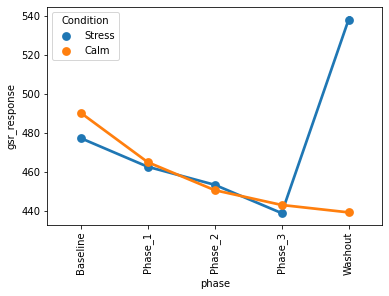

In [11]:
ax1 = sns.pointplot(x='phase',y='gsr_response', data=df[excludePhases], hue='Condition')
ax1.tick_params(axis='x', rotation=90)

In [97]:
ptxNames = pd.unique(df['Participant_ID'])
ptxNames

array(['AC071320', 'AM051035', 'AS121400S', 'AW151000', 'BG141500C',
       'CM141600', 'EH071522S', 'FB081150', 'ff051430', 'ff141100',
       'FK191530', 'gk141230c', 'hm191200', 'HR071630S', 'JB05114',
       'jm140930', 'js150930', 3, 'JW16', 'KE121300C', 'ks101500',
       'LC051345', 'LC071330C', 'LW121217S', 'MS071615C', 'NC151430',
       'NJ191000', 'OS121430C', 'RF141630', 'RH121500S', 'RI141030C',
       'RU1410000', 'sa191430', 'SK141430', 'TA191600', 'th191100',
       'VR051529', 'ws041257', 'xd', 'yu191230', 'YW151300'], dtype=object)

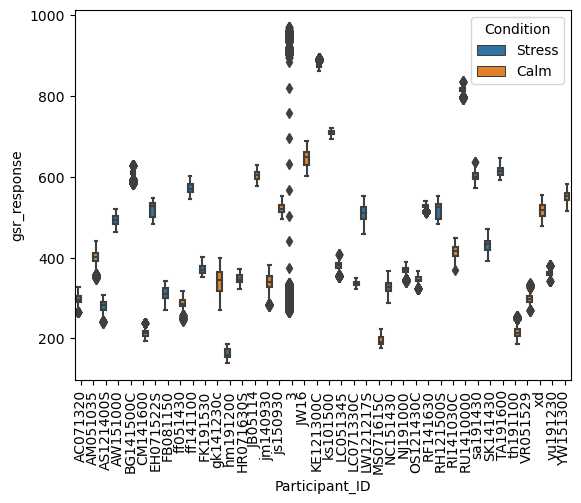

In [95]:
mask = df['phase'] == 'Washout'
ax1 = sns.boxplot(x='Participant_ID',y='gsr_response', data=df[mask], hue='Condition')
ax1.tick_params(axis='x', rotation=90)

### Heart rate 

In [90]:
# ax2 = sns.pointplot(x='phase', y='heart_rate', data=df[excludePhases], hue='Condition')
# ax2.tick_params(axis='x', rotation=90)

## 4. Hear-Rate-Variability (HRV) Computation

In [16]:
df

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,Stress,1
1,476,77,0.301579,startNow,AC071320,Stress,1
2,419,115,0.311549,startNow,AC071320,Stress,1
3,368,153,0.322520,startNow,AC071320,Stress,1
4,344,190,0.333490,startNow,AC071320,Stress,1
...,...,...,...,...,...,...,...
33383,313,920,361.040845,experiment_end,YW151300,Calm,0
33384,302,918,361.050817,experiment_end,YW151300,Calm,0
33385,293,916,361.061789,experiment_end,YW151300,Calm,0
33386,277,914,361.072759,experiment_end,YW151300,Calm,0


### Compute the Heart Rate Varibility (HRV) 
Use a window of a certain size (experiment with different window sizes) to compute this value

### RMSSD (Root Mean Square of Successive Differences)

In [68]:
# # Example trial from an example participant for testing and understanding HRV
# ptxes = pd.unique(df['Participant_ID'])
# testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')

# # Get the values into a new variable for ease of use 
# vals = df[testmask]['heart_rate'].values

# # Compute the sampling rate using time and number of samples 
# trialDuration = df[testmask]['time'].values[-1] - df[testmask]['time'].values[0] # in seconds 
# numbSamples = len(df[testmask]['time'].values)
# sampleRate = np.round(numbSamples/trialDuration)
# print("Sampling Rate: " + str(sampleRate) + " Hz")

# # Find the peaks using an arbitrary height value, i.e. ignore all peaks below that value e.g. 600
# pks,_ = find_peaks(vals,height=750, prominence=150, distance=25)

# heart_rate = len(pks) # number of peaks in a minute 
# RR = np.diff(pks)
# standardDeviationOfRR = np.std(RR)
# rmssd = np.sqrt(np.mean(np.square(np.diff(RR)))) # Same formula as Lily's document 

# print("Mean Heart Rate: " + str(heart_rate) + " ")
# print("SD of RR: " + str(standardDeviationOfRR) + " ")
# print("RMSSD: " + str(rmssd) + " ")
# # print("RR: " + str(RR) + " ")

# # Display plots of the heart rate and detected peaks 
# plt.plot(vals, color='r', linewidth=2)
# plt.plot(pks, vals[pks],'xk',markersize=8)
# plt.xlim([0,500])
# plt.xlabel('Time / s', fontsize=14)
# plt.ylabel('ECG', fontsize=14)

# plt.savefig('HeartRate_Example.png', dpi=600, bbox_inches='tight')

In [72]:
testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')
rmssdVal = HRV_Compute(df[testmask])
print('RMSSD: ' + str(rmssdVal))

RMSSD: 12.976526650164866


In [77]:
numbptx = pd.unique(df['Participant_ID'])
print('Number of participants: ' + str(len(numbptx)))

Number of participants: 44


In [78]:
rmssd = df.groupby(['Participant_ID', 'Condition', 'phase']).apply(lambda x: HRV_Compute(x))
rmssd

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\VR-Lab\AppData\Local\Temp\ipykernel_15152\1510568922.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  sampleRate = np.round(numbSamples/trialDuration)


Participant_ID  Condition  phase                 
3               Stress     Baseline                    85.856430
                           Phase_1                     66.867540
                           Phase_2                     58.985470
                           Phase_3                     14.633996
                           Washout                   3010.246028
                                                        ...     
yu191230        Stress     buggy_journey              413.000000
                           fix_buggy_instructions      20.346990
                           startNow                    24.050542
                           start_experiment             2.280351
                           storm_instructions          25.778975
Length: 445, dtype: float64

In [80]:
rmssd

Participant_ID  Condition  phase                 
3               Stress     Baseline                    85.856430
                           Phase_1                     66.867540
                           Phase_2                     58.985470
                           Phase_3                     14.633996
                           Washout                   3010.246028
                                                        ...     
yu191230        Stress     buggy_journey              413.000000
                           fix_buggy_instructions      20.346990
                           startNow                    24.050542
                           start_experiment             2.280351
                           storm_instructions          25.778975
Length: 445, dtype: float64

In [79]:
df['RMSSD'] = rmssd

TypeError: incompatible index of inserted column with frame index